This notebook contains the basics of *single cell RNA sequencing (scRNA-seq)* data processing, imputation and analysis methods. In @sec-introduction I include a brief explanation of the problem we are dealing with along with similar or related work that has been done up until today. In @sec-anndata I explain how to work with this type of data with python and the last section cover the main steps: processing the data such as normalizing and log-transforming it, imputing missing values and analyzing the results using clustering algorithms.

# Introduction {#sec-introduction}

Single cell RNA sequencing data is obtained, as its name says, at cell level. Each cell (observation) has thounsands of genes (feautures) in their transcriptomic background. Depending on the cells and their function, some genes will be expressed and some others no, which at the end comes down to having positive counts for a gene or none. At the end, the data we are deling with is a matrix containing *n observations* as rows and *m features* as columns, and each entry represents the counts of a particular gene in a particular cell.

The main problem we are dealing with are missing valuess, those values in the count matrix that correspond to a zero. Although, normally, the vast majority of genes are not expressed in a cell, truth is that when obtaining the transciptomic background there are many values that are lost, counting as zero some genes that may be expressed. This way, we can differentiate between two types of zeros in the matrix:

- **Biological zeros**: those that correspond to natural zeros, that is, genes that are trully not expressed in the cell.

- **Technical zeros**: expressed genes whose count has been lost in the adquisition process.

Here comes the motivation of coming up with a way to *fill* (*impute* in scRNA vocabulary) the technical zeros while preserving the biological ones. This means that we have two challenges, since we want to fill missing values without knowing which zeros correspond to one class or the other.


**Main imports and project structure**

First of all, we set the path to our main folder and do classical imports.

In [2]:
import os
os.chdir('/media/user/T7 Touch/PhD_Lucas/rna_sequencing/')

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import torch
import otscomics
import matplotlib.pyplot as plt

sc.settings.verbosity = 0 # errors (0), warnings (1), info (2), hints (3)

Just in case there are no missunderstanding when working with the directories, the tree structure of the project is printed below. See that the present notebook is inside the notebooks folder whereas the data we will be working on in on data/external.

In [4]:
!tree -d -L 3

.
├── data
│   ├── external
│   │   ├── pbmc3k
│   │   └── pbmc68k
│   └── internal
├── experiments
├── figures
├── models
├── notebooks
└── src
    └── __pycache__

11 directories


# Reading data as AnnData object {#sec-anndata}

The main library that we will be using is `scanpy` which contains multiple functions to both read the scRNA datasets as well as to process and visulize them.

All the experiments will be done using the PBMC-68k dataset. It is encoded in .mtx format and can be loaded as an AnnData object using the `.read_10x_mtx` function. The function asks for the path of the folder containing the .mtx file and the names we want to use for the genes (variables). By default it uses symbols but we can also call it with 'gene_ids'.

In [16]:
data_path = 'data/external/pbmc68k/'  # the directory with the `.mtx` file

adataCopy = sc.read_10x_mtx(
    path = data_path,            # the directory with the `.mtx` file
    var_names = 'gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache = False)    

By calling the AnnData object we can see that we have 5898240 cells (observations) and 32738 genes (variables). In this case, all the variables have a unique name (identifier) but in case that we get a warning, we can call `.var_names_make_unique()` to make all the variables names unique.

In [17]:
adataCopy

AnnData object with n_obs × n_vars = 5898240 × 32738
    var: 'gene_ids'

Names of cells and genes can be accesed by calling `.obs_names` and `.var_names` respectively.

## Adding annotations {#sec-annotations}

We also have a supplementary file containing the annotation for ~68k cells out of the ~5.8M, where they label each class in one out of 11 groups. To add the cell type to our data, we can read the .tsv file and since both the annotations and the `.obs` are dataframes, we can merge them by keys.

In [18]:
anno = pd.read_csv('data/external/pbmc68k/annotations.tsv', sep='\t')
anno.head()

,TSNE.1,TSNE.2,barcodes,celltype
0,7.565540,0.441370,AAACATACACCCAA-1,CD8+ Cytotoxic T
1,2.552626,-25.786672,AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic
2,-5.771831,11.830846,AAACATACCGGAGA-1,CD4+/CD45RO+ Memory
3,1.762556,25.979346,AAACATACTAACCG-1,CD19+ B
4,-16.793856,-16.589970,AAACATACTCTTCA-1,CD4+/CD25 T Reg


In [19]:
print("The lenght of the annotations file is:", len(anno))

The lenght of the annotations file is: 68579


We can see that the 'barcodes' column corresponds to the name of the cells. In order to not modify the original dataset (just in case we want to manipulate it later) we can make a copy of the AnnData object. We add a new column to the cells dataframe (obs) adding the values of the merged dataframe and lastly we drop all the cells that have NaN values (in the celltype column).

In [20]:
adata = adataCopy.copy()
inner = pd.merge(adata.obs, anno, left_index=True, right_on='barcodes', how='left')
adata.obs['celltype'] = inner['celltype'].values
idx = np.where(adata.obs['celltype'].notna())[0]
adata = adata[idx, :]

In [22]:
name = 'models/adata.h5ad'
adata.write(name)

print("AnnData object saved in:", name)

AnnData object saved in: models/adata.h5ad


# Data preprocessing {#sec-processing}

When working with scRNA data, there are some previous practices commonly done before doing the analysis [@sc-practices]. This is done because it has been proved that this preprocessing step helps not only computationally, but also giving better results when classifying the cells.

Some commonly used operations are:

- **Filtering**: this can be done to both cells and genes. In scRNA-seq vocabulary, this strictly means to get rid of those cells (*genes*) that has less than a certain amount of genes (*cells respectivly*).

- **Normalization per cell**: tipically the total number of genes counted on each cell vary a lot (even in order of magnitude) so it is quite common to chose a fixed number as total counts per cell. For usual imputation methods and clustering analysis, is quite common to use 1e6 as the total count (count per million). Nevertheless, we will also be using the <font color="red">OT distance, which works with probability distributions</font> and thus, the total count should be set to 1.

- **Log-transform**: typically $\log(x+1)$ is used. The one is added to avoid null values but also to keep the zeros untouched. This helps reducing the variance of the data. Nevertheless, this changes the probability distribution, so it should be only used in those analysis where the OT distance doesn't take part.

- **Sampling**: since we have a quite large datasets and computations are costly, we will also <font color="red">reduce the size of the dataset</font>. Cells will be reduced to a certain percentage keeping the same distribution than the original dataset and the number of genes by keeping only those that have the most variate features. In this case, we will keep around 10% of cells and reduce the genes to 1k approximatly.

## Filtering + normalization + log-transform {#sec-filtering}

In [32]:
adata = sc.read_h5ad("models/adata.h5ad")
adataFilter = adata.copy()

cells, genes = 3, 400
sc.pp.filter_cells(adataFilter, min_genes=genes)
sc.pp.filter_genes(adataFilter, min_cells=cells)

sc.pp.calculate_qc_metrics(adataFilter, percent_top=None, log1p=False, inplace=True)
sc.pp.normalize_total(adataFilter, target_sum=1)
sc.pp.log1p(adataFilter)

diff = np.array(adata.shape) - np.array(adataFilter.shape)
print(f"Filtered out {diff[0]} cells that have less than {genes} genes expressed")
print(f"Filtered out {diff[1]} genes that are detected in less than {cells} cells")
print("\nNew size of dataset:", adataFilter.shape)

Filtered out 9810 cells that have less than 400 genes expressed
Filtered out 15158 genes that are detected in less than 3 cells

New size of dataset: (58769, 17580)


As we can see, there are many cells and genes that are not enough expressed and so they act more like noise to our analysis than relevant information. Also, in the figure we can see that by taking the log-transform the data is better distributed and the deviation between counts is reduced and they are almost centered in 1, which is want we want to use them as probability distributions.

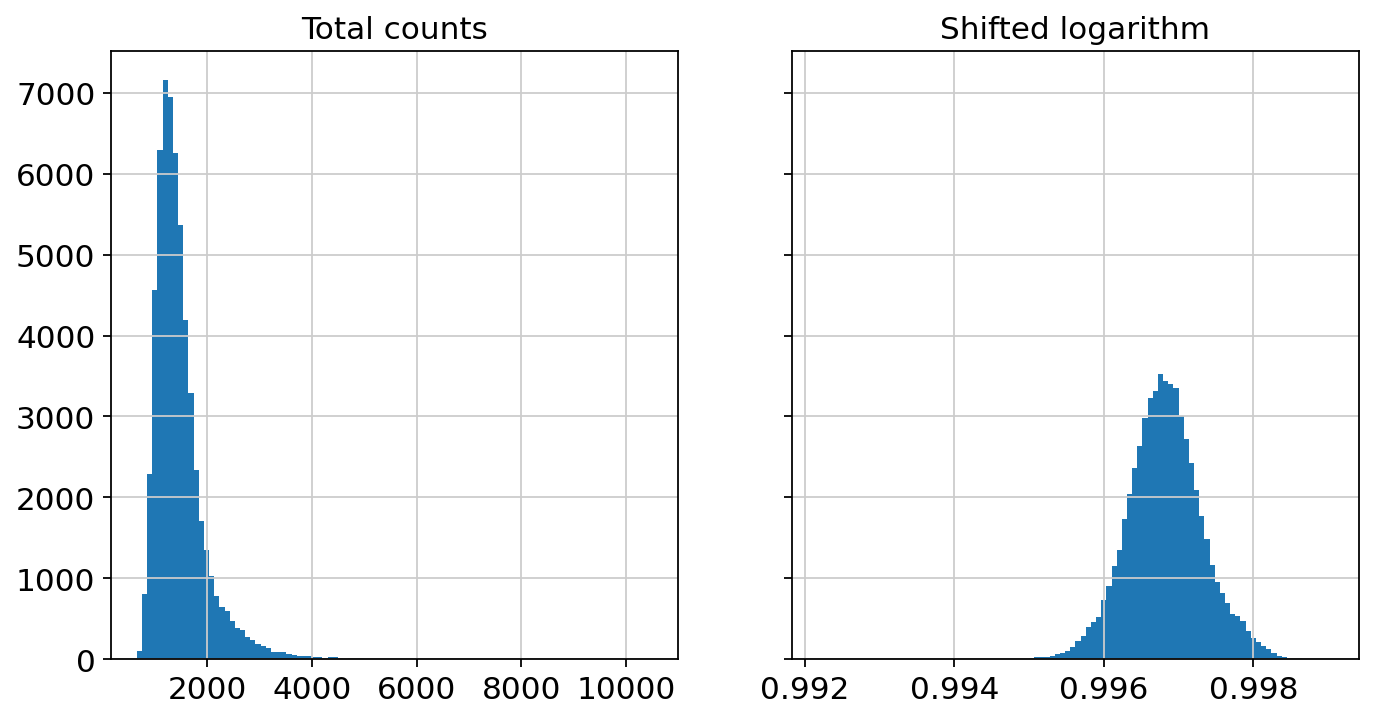

In [6]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))

ax1.set_title("Total counts")
ax1.hist(adata.obs["total_counts"], bins=100)

ax2.set_title("Shifted logarithm")
ax2.hist(adata.X.sum(1), bins=100)
plt.show()

In [33]:
name = 'models/adataFilter.h5ad'
adataFilter.write(name)

print("AnnData object saved in:", name)

AnnData object saved in: models/adataFilter.h5ad


## Sampling {#sec-sampling}

**Cell sampling**: we can start by sampling the cells to a 10% of their size keeping the same distribution. I recall that this is just to speed up computations (nice approximation to start up), but <font color="red">it is recommended to use all the observations for a formal analysis</font>.

In [36]:
import scipy.stats as stats

adata = sc.read_h5ad("models/adataFilter.h5ad")
cells_names = adata.obs_names
class_labels = adata.obs['celltype']

# Stratify the data
strata = {}
for label in class_labels.unique():
    strata[label] = cells_names[class_labels == label]

# Calculate sample sizes
strata_sample_sizes = {
    label: int(0.1 * len(stratum)) for label, stratum in strata.items()
}

# Perform stratified sampling
sample_names = np.array([])
for label, stratum in strata.items():
    sample_size = strata_sample_sizes[label]
    sample_names = np.concatenate((sample_names, np.random.choice(stratum, sample_size)))

idxs = np.where(np.isin(adata.obs_names, sample_names))[0]
adataSample = adata[idxs]

diff = np.array(adata.shape) - np.array(adataSample.shape)
print(f"Sampled {adataSample.shape[0]} cells from a total of {adata.shape[0]}")
print('\nNew size of dataset:', adataSample.shape)

Sampled 5601 cells from a total of 58769

New size of dataset: (5601, 17580)


In [37]:
name = 'models/adataSample.h5ad'
adataSample.write(name)

print("AnnData object saved in:", name)

AnnData object saved in: models/adataSample.h5ad


## Cell type distribution

To verify that the sampled has been correctly done, we can compare the distribution of cell types along the three different dataset: the orgininal, the one filtered by number of cells and genes expressed and the sampled where we reduce the number of observations. As we can see, we are dealing with an unbalanced dataset, where the two most representative cell types cover 55% of the dataset and the first three 70%.

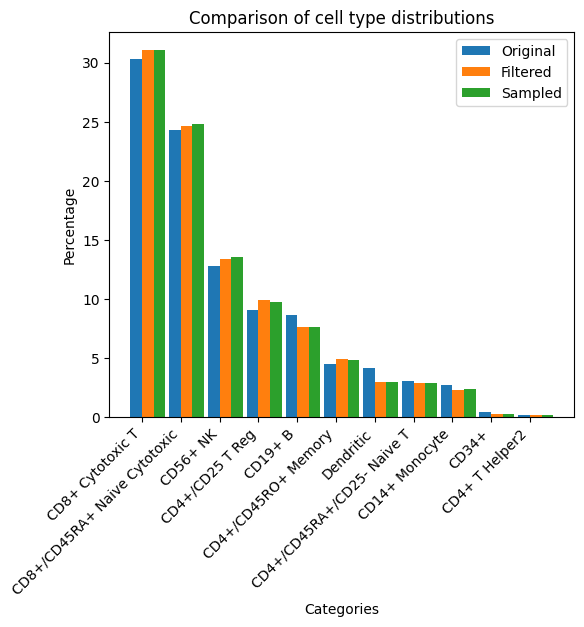

In [154]:
import seaborn as sns

adata = sc.read_h5ad("models/adata.h5ad")
adataFilter = sc.read_h5ad("models/adataFilter.h5ad")
adataSample = sc.read_h5ad("models/adataSample.h5ad")

dic = {"Original": adata,
       "Filtered": adataFilter,
       "Sampled": adataSample}

i=0
bar_width = 0.3
r = np.arange(11)
fig, ax = plt.subplots(figsize=(6,5))
for key,data in dic.items():
    values = data.obs['celltype'].value_counts(normalize=True) * 100
    labels = values.index

    idx = [x + i*bar_width for x in r]
    i += 1
    ax.bar(idx, values, width=bar_width, label=key)

# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels, rotation=45, ha='right')
plt.title('Comparison of cell type distributions')
plt.legend()

plt.show()

**Genes sampling**: to select the genes that vary the most, we can either compute the *standar deviation (std)* or use the `sc.pp.highly_variable_genes` function. This last one will create a boolean variable in the genes indicating if they are or not among the most variate ones (regarding a threshold) but using a different metric than the *std*.

In [41]:
adata = sc.read_h5ad("models/adataSample.h5ad")

n_genes = 3000
stds = np.argsort(np.std(adata.X.toarray(), 0))  # idx of sorted stds
std_idx = stds[::-1][:n_genes]

adataStd = adata[:, std_idx]

sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)
hv_idx = np.where(adata.var['highly_variable'])[0]

adataHv = adata[:, hv_idx]

print('\nNew size of dataset:', adataHv.shape)


New size of dataset: (5601, 3000)


/home/lucas/envs/rna-seq/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


This way, we end up with a much smaller dataset, where cells and genes have been filtered to reduce the noise and every cell count sum adds up (*almost*) to 1.

In [42]:
name1 = 'models/adataHv.h5ad'
name2 = 'models/adataStd.h5ad'
adataHv.write(name1)
adataStd.write(name2)

print("AnnData object saved in:", name1)
print("AnnData object saved in:", name2)

AnnData object saved in: models/adataHv.h5ad
AnnData object saved in: models/adataStd.h5ad


## Genes distribution

We can do something similar to the barplot containing the cell type distribution, but this time with the most expressed genes. Not to say that we cannot perform a barplot of all genes since we are dealing with 3k for the filtered dataset and over 32k for the original one.

In [42]:
adata = sc.read_h5ad("models/adata.h5ad")
adataFilter = sc.read_h5ad("models/adataFilter.h5ad")
adataHv = sc.read_h5ad("models/adataHv.h5ad")
adataStd = sc.read_h5ad("models/adataStd.h5ad")

dic = {"Original": adata,
       "Filtered": adataFilter,
       "Highly variable": adataHv,
       "Std": adataStd}

for key,data in dic.items():
    sc.pl.highest_expr_genes(
        adata, n_top=30, show=False, save=f'{key}.png'
    )

Text(0.5, 0.95, 'Comparison of cell type distributions')

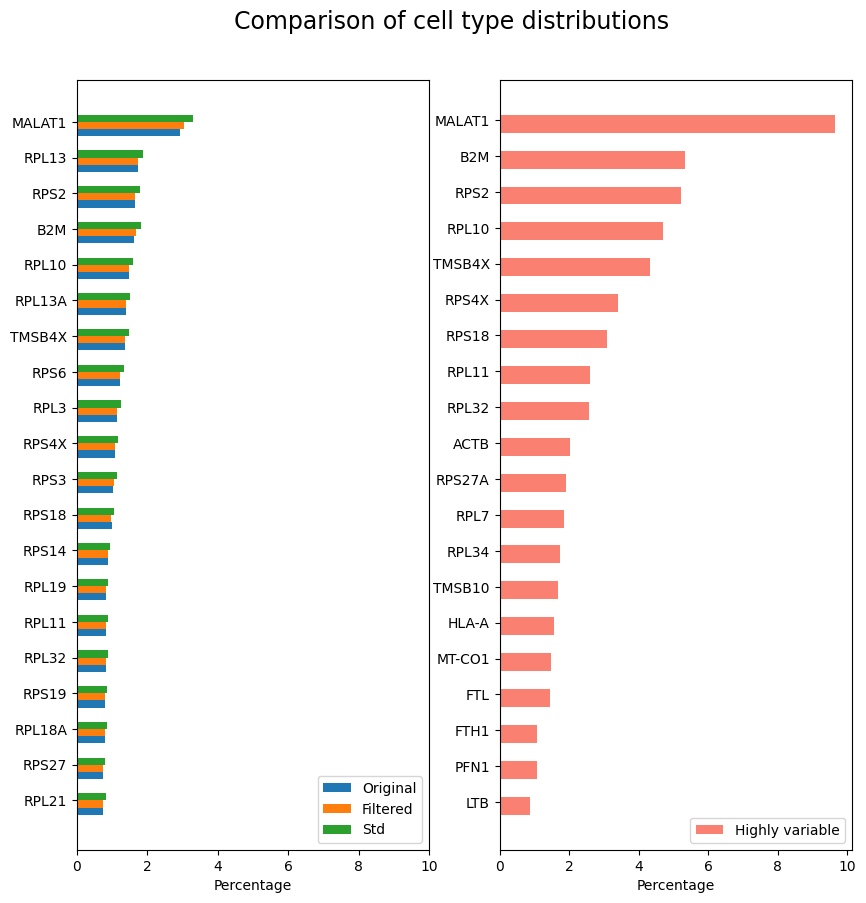

In [143]:
adata = sc.read_h5ad("models/adata.h5ad")
adataFilter = sc.read_h5ad("models/adataFilter.h5ad")
adataHv = sc.read_h5ad("models/adataHv.h5ad")
adataStd = sc.read_h5ad("models/adataStd.h5ad")

dic = {"Original": adata,
       "Filtered": adataFilter,
       "Std": adataStd}

i = 0
bar_width = 0.2
n_genes = 20
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for key,data in dic.items():
    sc.pp.calculate_qc_metrics(data, inplace=True)
    data.var['percentage'] = data.var['total_counts'] / data.var['total_counts'].sum() * 100

labels = adata.var['percentage'].sort_values(ascending=False)[:n_genes].index
labels1 = labels[::-1]
r = np.arange(len(labels))
for key,data in dic.items():
    values = data.var['percentage'].loc[labels1]
    idx = [x + i*bar_width for x in r]
    i += 1
    ax[0].barh(idx, values, height=bar_width, label=key)

# Customize the plot
ax[0].set_xlabel(f'Percentage')
ax[0].set_yticks([r + 1.5*bar_width for r in range(len(labels))], labels1)
ax[0].set_xlim(0,10)
ax[0].legend(loc='lower right')

sc.pp.calculate_qc_metrics(adataHv, inplace=True)
adataHv.var['percentage'] = adataHv.var['total_counts'] / adataHv.var['total_counts'].sum() * 100
values = adataHv.var['percentage'].sort_values(ascending=False)[:n_genes]
values = values.sort_values()
labels2 = values.index
ax[1].barh(idx, values, height=0.5, label='Highly variable', color='salmon')

# Customize the plot
ax[1].set_xlabel(f'Percentage')
ax[1].set_yticks([r+0.5 for r in range(len(labels2))], labels2, ha='right')
ax[1].legend(loc='lower right')

fig.suptitle('Comparison of cell type distributions', y=0.95, fontsize=17)

# Distance metrics {#sec-distances}

In this section we will perform some distance matrix to the count data. The content is based on [@cell-cell]. This way, we will try to distinguish cell-to-cell similarity using different metrics, including OT distance. To do so, we will compute the <font color="red">distance matrix between cells using their transcriptomic vector</font>, so that the matrix has dimension n_cells x n_cells.

First we get the name of the cell type classification (11 different labels) and we sort them by label so that, at the moment of visualization, each cluster is together.

In [5]:
adata = sc.read_h5ad('models/adataSample.h5ad')  # load processed AnnData
clusters = adata.obs['celltype']                 # get the cell type df
idx = np.argsort(clusters.values)                # idx of sorted array

print("The 11 labels for cell type classification are:\n")
print(np.unique(clusters))

The 11 labels for cell type classification are:

['CD14+ Monocyte' 'CD19+ B' 'CD34+' 'CD4+ T Helper2' 'CD4+/CD25 T Reg'
 'CD4+/CD45RA+/CD25- Naive T' 'CD4+/CD45RO+ Memory' 'CD56+ NK'
 'CD8+ Cytotoxic T' 'CD8+/CD45RA+ Naive Cytotoxic' 'Dendritic']


## Conventional metrics {#sec-metrics}

We first compute the distance matrix using four different conventional metrics: *Euclidean, Manhattan, Cosine and Pearson*. We do it using the two different approaches to sample the genes (using *highly variable* and *std*) so that we can compare their behaviour.

In [6]:
from scipy.spatial.distance import cdist

metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']

adataHv = sc.read_h5ad('models/adataHv.h5ad') 
adataStd = sc.read_h5ad('models/adataStd.h5ad') 

data_hv = adataHv.X.toarray()
data_std = adataStd.X.toarray()

matrices_hv, matrices_std = [], []
for metric in metrics:
    print(f"Computing {metric} distance for first dataset")
    A = cdist(data_hv, data_hv, metric)
    A /= A.max()

    print(f"Computing {metric} distance for second dataset\n")
    B = cdist(data_std, data_std, metric)
    B /= B.max()

    matrices_hv.append(A)
    matrices_std.append(B)

Computing euclidean distance for first dataset
Computing euclidean distance for second dataset

Computing cityblock distance for first dataset
Computing cityblock distance for second dataset

Computing cosine distance for first dataset
Computing cosine distance for second dataset

Computing correlation distance for first dataset
Computing correlation distance for second dataset



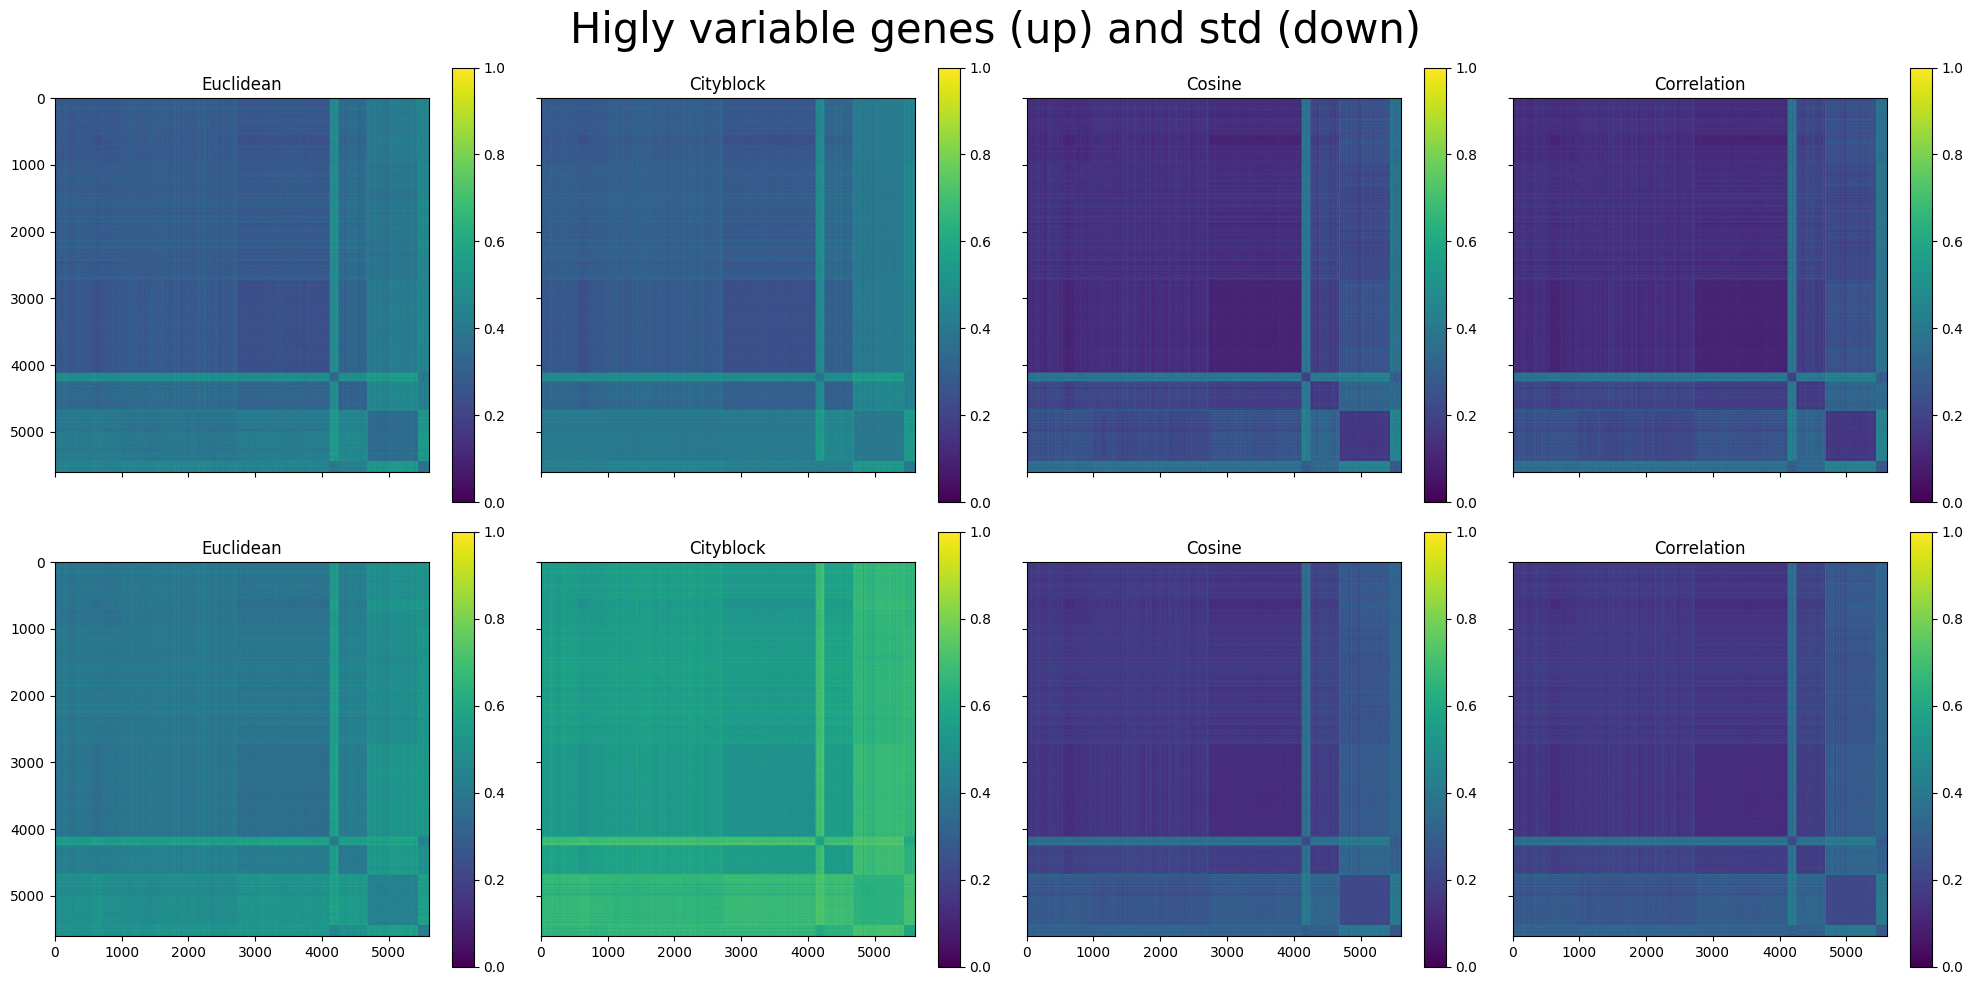

In [7]:
fig, axes = plt.subplots(
    nrows=2, ncols=4,
    sharex=True, sharey=True,
    figsize=(20,10)
)

for i in range(len(metrics)):

    im_hv = axes[0, i].imshow(matrices_hv[i][idx][:,idx])
    # axes[0, i].axis('Off')
    axes[0, i].set_title(metrics[i].title())
    fig.colorbar(im_hv)

    im_std = axes[1, i].imshow(matrices_std[i][idx][:,idx])
    # axes[1, i].axis('Off')
    axes[1, i].set_title(metrics[i].title())
    fig.colorbar(im_std)

plt.suptitle("Higly variable genes (up) and std (down)", fontsize=30)
plt.tight_layout()
plt.show()

We can see that they *cluster* the data in five groups of cells (diagonal blocks) and the metrics seem to behave similarly for both datasets, being *Cosine* and *Pearson correlation* the ones outputing the best results.

## OT distance {#sec-ot}

When computing the OT distance, as explained in [@cell-cell], they obtained the best results for real scRNA data using the *cosine* distance for calculating the cost matrix for the OT problem.

In [6]:
data = adataFilter.X.toarray().astype(np.double)
data += 1e-9
data = (data.T/data.sum(1)).T

In [7]:
C = otscomics.cost_matrix(data.T, 'cosine')
D_ot, errors = otscomics.OT_distance_matrix(
    data=data.T, cost=C, eps=.1,
    dtype=torch.double, device='cuda'
)

np.save('D_ot.npy', D_ot)

  0%|          | 3/15554253 [00:00<860:10:18,  5.02it/s] /home/user/environments/rna-seq/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


In [ ]:
# adataFilterHv = sc.read_h5ad('models/adataFilter.h5ad') 
# adataFilterStd = sc.read_h5ad('models/adataFilterStd.h5ad') 

# sc.pp.normalize_total(adataFilterHv, target_sum=1)
# sc.pp.log1p(adataFilterHv)
# sc.pp.normalize_total(adataFilterStd, target_sum=1)
# sc.pp.log1p(adataFilterStd)

# data_hv = adataFilterHv.X.T.toarray().astype(np.double)
# data_std = adataFilterStd.X.T.toarray().astype(np.double)

matrices = []
for i,data in enumerate([data_hv, data_std]):
    print(i)
    C = otscomics.cost_matrix(data, 'cosine')
    D_ot, errors = otscomics.OT_distance_matrix(
        data=data, cost=C, eps=.1,
        dtype=torch.double, device='cuda'
    )

    matrices.append(D_ot)

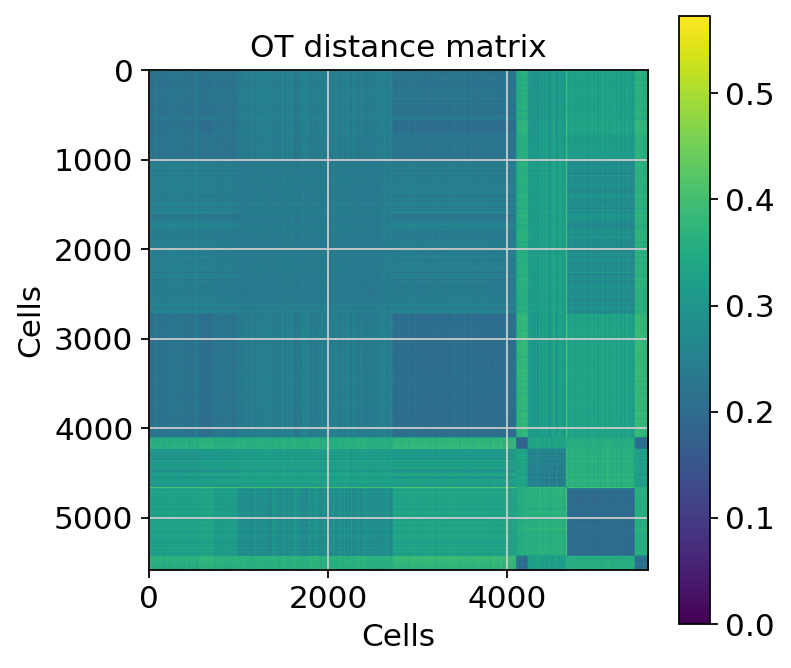

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(D_ot[idx][:,idx])
fig.colorbar(im)
plt.title('OT distance matrix')
plt.xlabel('Cells')
plt.ylabel('Cells')
plt.show()

# Imputation methods {#sec-imputation}

Once we have filtered and process our data, we can pass to the imputation process, meaning that we can try to use different methods (ALRA, MAGIC and SinkHorn) in order to recover the technical-zeros from the sparse matrix. In this case, we will compare how good or bad the data is grouped in clusters depending on the imputation methods used, as well as the original raw data. This clusters will be compared with the true labels where each cell is classified in one out of eleven cell types. This type of analysis is based on the review [@sc-review] where they compare a good amount of imputation mehtods.

In [14]:
adataHv = sc.read_h5ad('models/adataHv.h5ad') 
adataStd = sc.read_h5ad('models/adataStd.h5ad')

dataList = {"Hv": adataHv, "Std": adataStd}

## ALRA {#sec-alra}

This method is developed in [@zero-preserving]. It consists in taking a low-rank approximation of the count matrix to impute all missing values (*technical* + *biological* zeros) and then recover the true zeros (*biological*) using a hipothesis in the data distribution. They assume that all biological zeros of the same gene are simmetrically distributed around 0.

![Overview of the ALRA imputation scheme. A Measured expression matrix contains technical zeros (in each block) and biological zeros (outside
each block). B Low-rank approximation via SVD results in a matrix where every zero is completed with a non-zero value (i.e., biological zeros are not
preserved). C The elements corresponding to biological zeros for each gene are symmetrically distributed around 0, so the magnitude of the most negative
elements in each row is also approximately the magnitude of the most positive values assigned to biological zeros. Therefore, thresholding the values in
each row, restores almost all of the biological zeros in the imputed matrix (D).](../figures/alra.png){#fig-alra}

In [19]:
from src.ALRA import choose_k, ALRA

for key,data in dataList.items():
    normalizedMatrix = data.X.toarray().astype(float)

    k = choose_k(normalizedMatrix)
    A_alra = ALRA(normalizedMatrix, k)

    adataALRA = ad.AnnData(A_alra)
    adataALRA.obs_names = data.obs_names
    adataALRA.obs['celltype'] = data.obs['celltype']
    adataALRA.var_names = data.var_names

    name = f'models/adataALRA{key}.h5ad'
    adataALRA.write(name)

    print("AnnData object saved in:", name)

AnnData object saved in: models/adataALRAHv.h5ad
AnnData object saved in: models/adataALRAStd.h5ad


## MAGIC {#sec-magic}

In [22]:
import scprep
import magic

for key,data in dataList.items():
    normalizedMatrix = data.X.toarray().astype(float)

    magicOP = magic.MAGIC()
    A_magic = magicOP.fit_transform(normalizedMatrix, genes='all_genes')
    adataMAGIC = ad.AnnData(A_magic)

    adataMAGIC.obs_names = data.obs_names
    adataMAGIC.obs['celltype'] = data.obs['celltype']
    adataMAGIC.var_names = data.var_names

    name = f'models/adataMAGIC{key}.h5ad'
    adataMAGIC.write(name)

    print("\nAnnData object saved in:", name)

Calculating MAGIC...
  Running MAGIC on 5601 cells and 3000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 3.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.86 seconds.
    Calculating affinities...
    Calculated affinities in 2.83 seconds.
  Calculated graph and diffusion operator in 8.91 seconds.
  Calculating imputation...
  Calculated imputation in 0.99 seconds.
Calculated MAGIC in 9.93 seconds.

AnnData object saved in: models/adataMAGICHv.h5ad
Calculating MAGIC...
  Running MAGIC on 5601 cells and 3000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.54 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.16 seconds.
    Calculating affinities...
    Calculated affinities in 2.97 seconds.
  Calculated graph and diffusion operator in 8.67 seconds.
  Calculating imputation...
  Calculated imputation in 1.06 seconds.
Calculated MAGIC in 9.7

## Sinkhorn {#sec-sinkhorn}

In [23]:
from hyperimpute.plugins.imputers import Imputers

for key,data in dataList.items():
    normalizedMatrix = data.X.toarray().astype(float)

    normalizedMatrix[normalizedMatrix == 0] = np.nan

    plugin = Imputers().get("sinkhorn")
    df_sink = plugin.fit_transform(normalizedMatrix)
    normalizedMatrix = np.array(df_sink)

    adataSink = ad.AnnData(normalizedMatrix)
    adataSink.obs_names = data.obs_names
    adataSink.obs['celltype'] = data.obs['celltype']
    adataSink.var_names = data.var_names

    name = f'models/adataSink{key}.h5ad'
    adataSink.write(name)

    print("AnnData object saved in:", name)

AnnData object saved in: models/adataSinkHv.h5ad
AnnData object saved in: models/adataSinkStd.h5ad


# Visualization {#sec-visualization}

One of the previous steps before analysing the data is to treat it so that the statisticals computations make more sense. In this case, we know that scRNA-sequencing suffers from the so called 'curse of dimensionalty'. Even though we tend to think that the more features (genes) the best to classify the observations, it is not always true. This often happens in this field where the number of variables is too high, so that there are many of them that don't actually add information, but rather noise.

In [24]:
adataHv = sc.read_h5ad('models/adataHv.h5ad')
adataStd = sc.read_h5ad('models/adataStd.h5ad')

adataALRAHv = sc.read_h5ad('models/adataALRAHv.h5ad')
adataALRAStd = sc.read_h5ad('models/adataALRAStd.h5ad')

adataMAGICHv = sc.read_h5ad('models/adataMAGICHv.h5ad')
adataMAGICStd = sc.read_h5ad('models/adataMAGICStd.h5ad')

adataSinkHv = sc.read_h5ad('models/adataSinkHv.h5ad')
adataSinkStd = sc.read_h5ad('models/adataSinkStd.h5ad')

dataList = {"Raw Hv": adataHv, "Raw Std": adataStd,
            "ALRA Hv": adataALRAHv, "ALRA Std": adataALRAStd,
            "MAGIC Hv": adataMAGICHv, "MAGIC Std": adataMAGICStd,
            "Sink Hv": adataSinkHv, "Sink Std": adataSinkStd,
}

## Dimensionality reduction

PCA creates a new set of uncorrelated variables, so called principle components (PCs), via an orthogonal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC amounts to the largest possible variance. PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

In order to apply it to our data, first we need to perform the method via `.tl.pap` or `.pp.pca` (they are actually the same function) and then scatter plot it using `.pl.pca`. To plot it we only need to pass the AnnData object since it will look for the components saved in `uns`, `obsm` and `varm`. In case we want the scatter plot to be colored, we can add which variable to take into account (or cell/gene).

In [25]:
for key,data in dataList.items():
    sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)
    sc.tl.pca(data, svd_solver='arpack', n_comps=30)
    sc.pl.pca_variance_ratio(data, log=True, n_pcs=30, show=False, save=f'{key}.png')

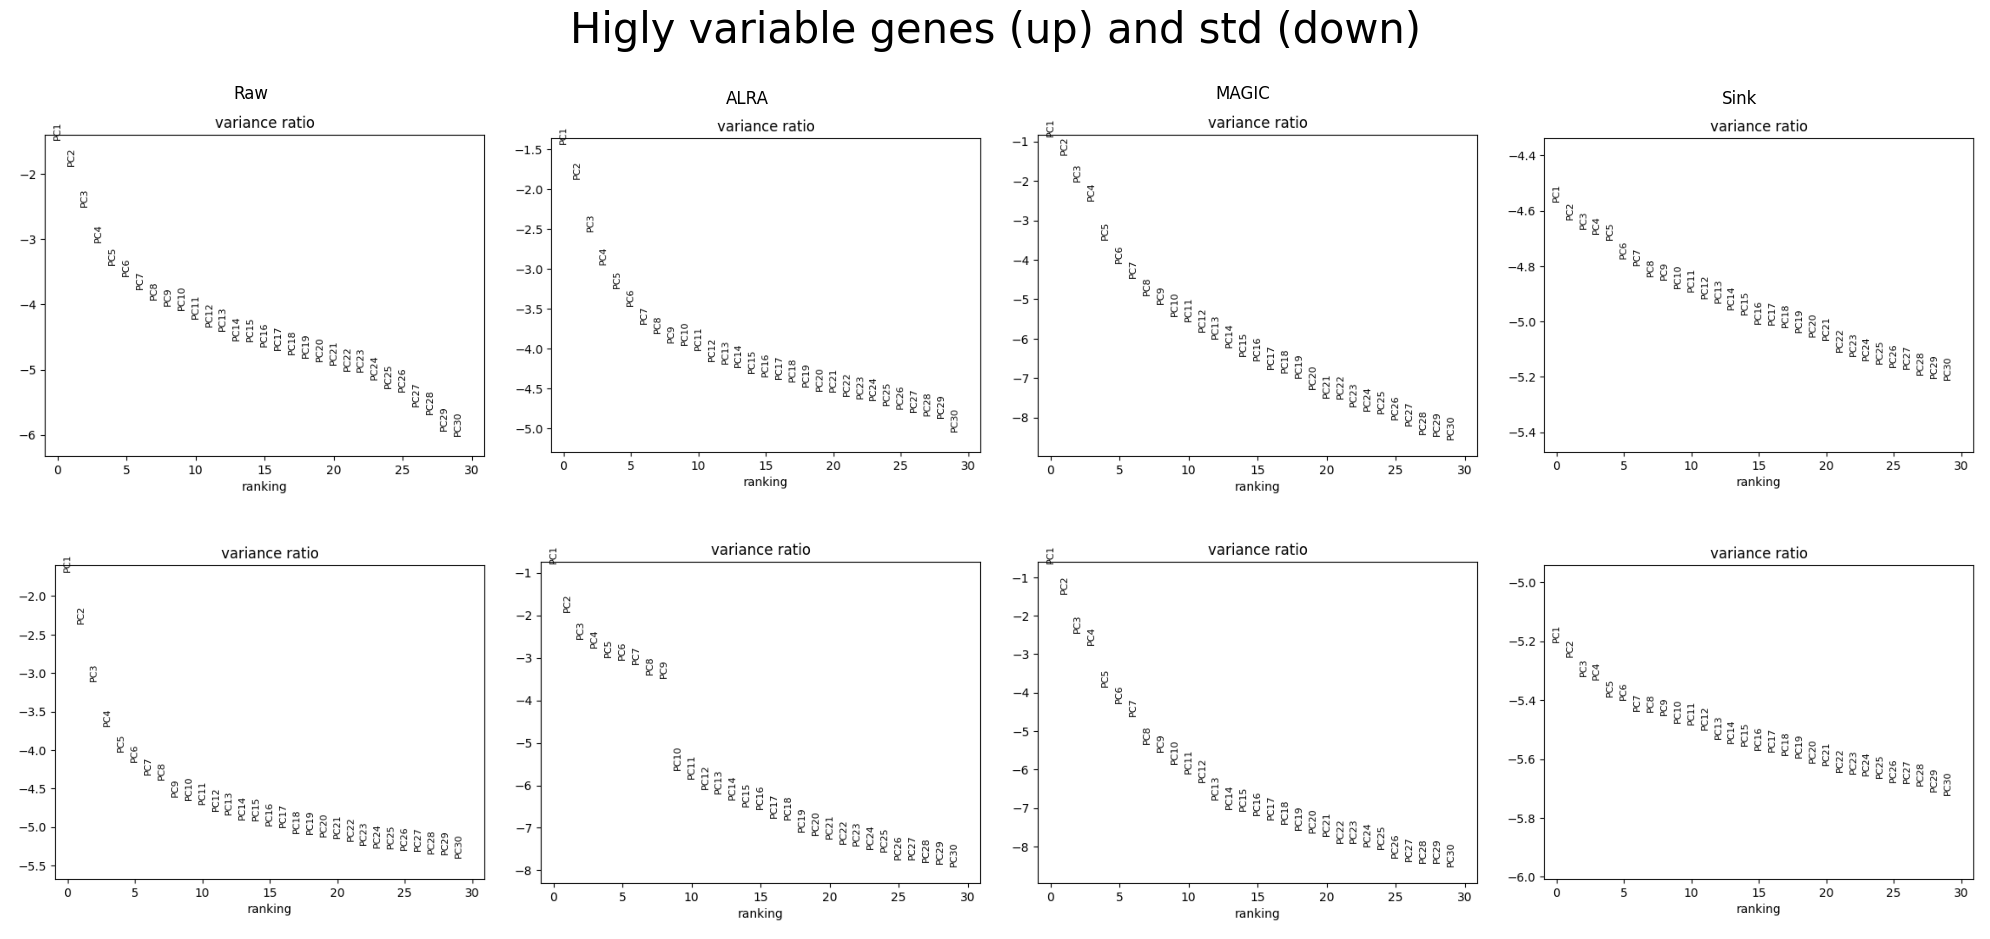

In [37]:
from PIL import Image

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

path = '/media/user/T7 Touch/PhD_Lucas/rna_sequencing/figures'
figs = os.listdir(path)
for i in range(len(figs)):

    img = np.asarray(Image.open(f'{path}/{figs[i]}'))
    row, col = i%2, i//2
    im = axes[row, col].imshow(img)
    axes[row, col].axis('Off')

axes[0, 0].set_title("Raw", size='large')
axes[0, 1].set_title("ALRA", size='large')
axes[0, 2].set_title("MAGIC", size='large')
axes[0, 3].set_title("Sink", size='large')

plt.suptitle("Higly variable genes (up) and std (down)", fontsize=30)
plt.tight_layout()
plt.show()

## Clustering

Once one has performed the reduciton of dimension to the data, we can actually visulize it in a 2D or 3D graph. Then, clustering mehtods can be applied to this reduced data in order to group the principal components. To do so, we can use different clustering mehtods available in the `scanpy` module. Here we will show two of them, which make use of a graph structure on the data.

That is why we will need first to calculate the KNN graph on the lower-dimentional data using the `.pp.neighbors`. Appart from the data, we also need to provide the number of principal components we want to use (how many dimensions out of the total ones we want to keep). This is an important choice and it will depend on the percentage of information that each principal component carries. We can see this using the `.pl.pca_variance_ratio` function over the data.

We can perform this algorithm using the `.tl.leiden` function and by passing the reduced data with the KNN graph already performed and the resolution parameter (1 by default) which quantifies (in a way) the number of clusters. We can also pass the `neighbors_key` in case we have performed multiple KNN graphs and the `key_added` is case we use different resolutions parameters to compare them.

In [38]:
from sklearn.cluster import KMeans

for key,data in dataList.items():

    matrix = data.X
    if type(matrix) != np.ndarray:
        matrix = matrix.toarray()

    kmeans = KMeans(n_clusters=11, random_state=0, n_init="auto").fit(matrix)
    data.obs['kmeans'] = kmeans.labels_
    data.obs['kmeans'] = data.obs['kmeans'].astype('string')
    print('KMeans performed on', key)

KMeans performed on Raw Hv
KMeans performed on Raw Std
KMeans performed on ALRA Hv
KMeans performed on ALRA Std
KMeans performed on MAGIC Hv
KMeans performed on MAGIC Std
KMeans performed on Sink Hv
KMeans performed on Sink Std


In [39]:
for key,data in dataList.items():
    sc.pp.neighbors(data, n_pcs=20, use_rep='X')
    sc.tl.umap(data)
    print('UMAP performed on', key)

/home/user/environments/rna-seq/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP performed on Raw Hv
UMAP performed on Raw Std
UMAP performed on ALRA Hv
UMAP performed on ALRA Std
UMAP performed on MAGIC Hv
UMAP performed on MAGIC Std
UMAP performed on Sink Hv
UMAP performed on Sink Std


In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

for key,data in dataList.items():
    # Convert string labels to numerical labels
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(data.obs['celltype'])
    kmeans_labels = data.obs['kmeans'].astype(int)

    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(true_labels, kmeans_labels)

    # Calculate Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(true_labels, kmeans_labels)

    print(key)
    print("Adjusted Rand Index (ARI):", np.round(ari, 3))
    print("Normalized Mutual Information (NMI):", np.round(nmi, 3),'\n')

Raw Hv
Adjusted Rand Index (ARI): 0.159
Normalized Mutual Information (NMI): 0.336 

Raw Std
Adjusted Rand Index (ARI): 0.164
Normalized Mutual Information (NMI): 0.339 

ALRA Hv
Adjusted Rand Index (ARI): 0.171
Normalized Mutual Information (NMI): 0.344 

ALRA Std
Adjusted Rand Index (ARI): 0.173
Normalized Mutual Information (NMI): 0.352 

MAGIC Hv
Adjusted Rand Index (ARI): 0.155
Normalized Mutual Information (NMI): 0.342 

MAGIC Std
Adjusted Rand Index (ARI): 0.171
Normalized Mutual Information (NMI): 0.355 

Sink Hv
Adjusted Rand Index (ARI): 0.0
Normalized Mutual Information (NMI): 0.006 

Sink Std
Adjusted Rand Index (ARI): 0.001
Normalized Mutual Information (NMI): 0.005 



In [ ]:
save=f'{key}.png'

In [ ]:
for key,data in dataList.items():
    sc.pl.umap(data,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', key],
           legend_loc="right margin",
           wspace=0.5,
           show=False,
           save=f'{key}.png'
)

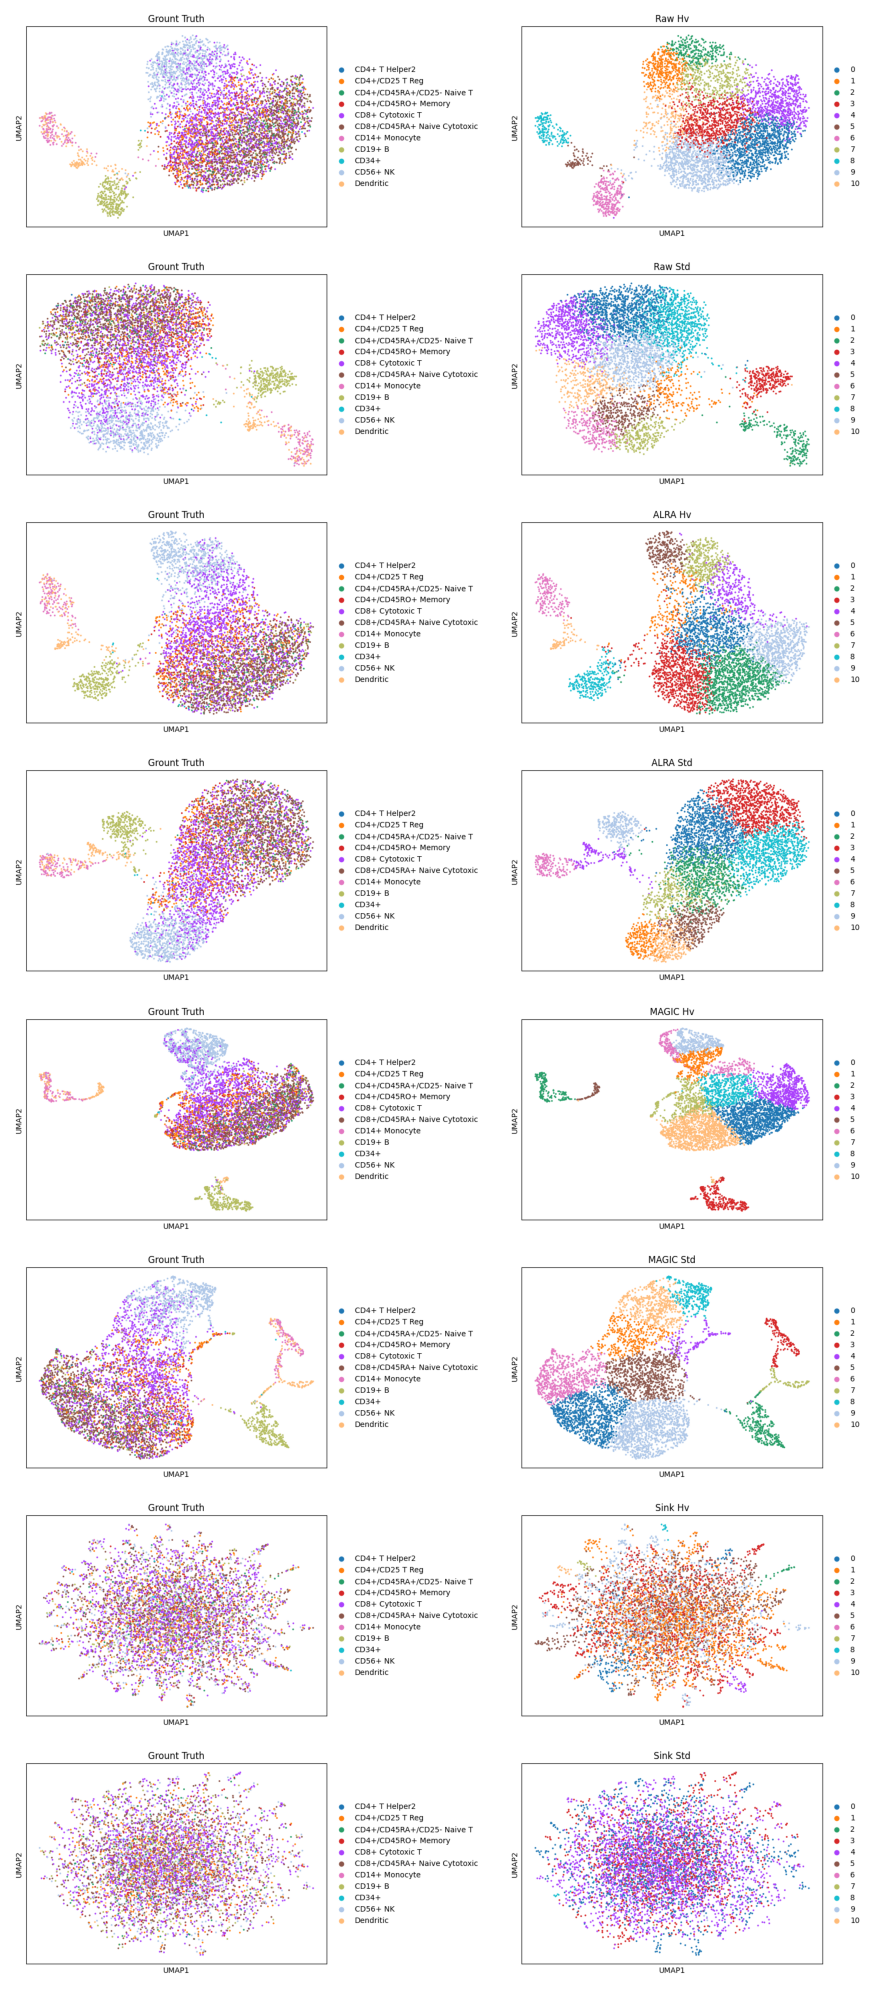

In [56]:
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(40,20))

path = '/media/user/T7 Touch/PhD_Lucas/rna_sequencing/figures'
figs = [i for i in os.listdir(path) if i.startswith('umap')]
for i in range(len(figs)):

    img = np.asarray(Image.open(f'{path}/{figs[i]}'))
    im = axes[i].imshow(img)
    axes[i].axis('Off')

plt.tight_layout()
plt.show()